# Introduction

I wanted to test the idea that we could use dimensionality reduction to explore our index sorting flow data, to come up with an optimal gating strategy for all the different markers.

I don't think this has really been done before, so I wanted to try it out to see if it would work before writing it up for you! And it seems to work quite well!

# Imports

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.manifold import TSNE
from sklearn import manifold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from ipywidgets import *

# Load data

In [2]:
data = pd.read_csv("nonew.csv", thousands=',')
#np.random.seed(42)

In [3]:
data.head()

,Well,Plate,CD41_APCH7,ANXA1_APC,Zombie_violet,PVR_PECy7,CD51_FITC,VEGFR1_594,CD168_700,Colony
0,A1,1,1297,502,75,1723,200,61,2315,Y
1,A2,1,-53,-89,21,626,138,93,3061,N
2,A3,1,372,212,69,929,197,44,604,N
3,A4,1,984,407,164,312,790,253,279,N
4,A5,1,5036,1246,153,1121,914,266,3167,N


In [4]:
data_clean = data.drop(["Well", "Plate"], axis=1)

In [5]:
data_clean.head()

,CD41_APCH7,ANXA1_APC,Zombie_violet,PVR_PECy7,CD51_FITC,VEGFR1_594,CD168_700,Colony
0,1297,502,75,1723,200,61,2315,Y
1,-53,-89,21,626,138,93,3061,N
2,372,212,69,929,197,44,604,N
3,984,407,164,312,790,253,279,N
4,5036,1246,153,1121,914,266,3167,N


In [6]:
X = data_clean.iloc[:,:-1]

In [7]:
Y = data_clean.iloc[:,-1:]

# Dimensionality reduction

<IPython.core.display.Javascript object>


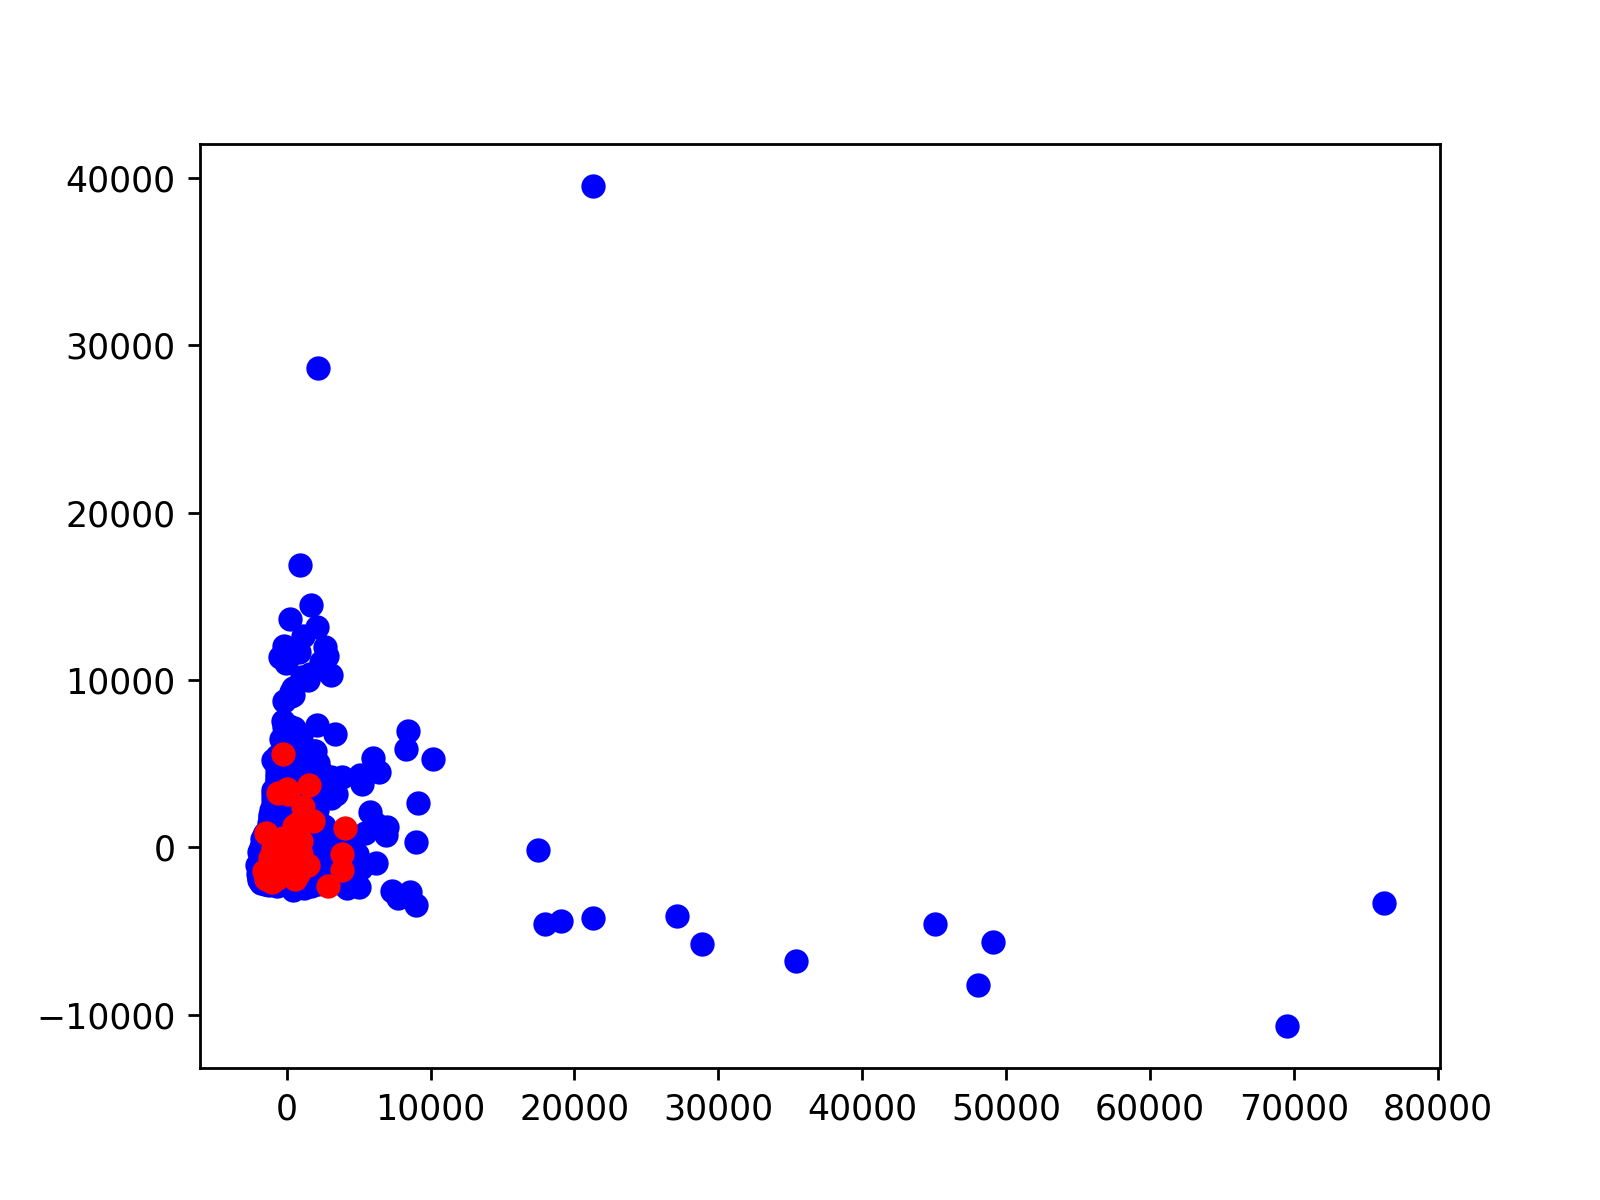

In [18]:
%matplotlib notebook
pca = PCA(n_components=2)
X_ = pca.fit_transform(X)

nonprog_a, nonprog_b = [], []
prog_a, prog_b = [], []
for i in range(len(Y.values.tolist())):
    if Y.values.tolist()[i][0] == "Y":
        prog_a.append(X_[i, 0])
        prog_b.append(X_[i, 1])
    else:
        nonprog_a.append(X_[i, 0])
        nonprog_b.append(X_[i, 1])

plt.scatter(nonprog_a[:], nonprog_b[:], c=[[0,0,1]], cmap=plt.cm.Spectral)
plt.scatter(prog_a[:], prog_b[:], c=[[1,0,0]], cmap=plt.cm.Spectral)
plt.axis('tight')

plt.show()

# Perform gating on PCA plot

<IPython.core.display.Javascript object>


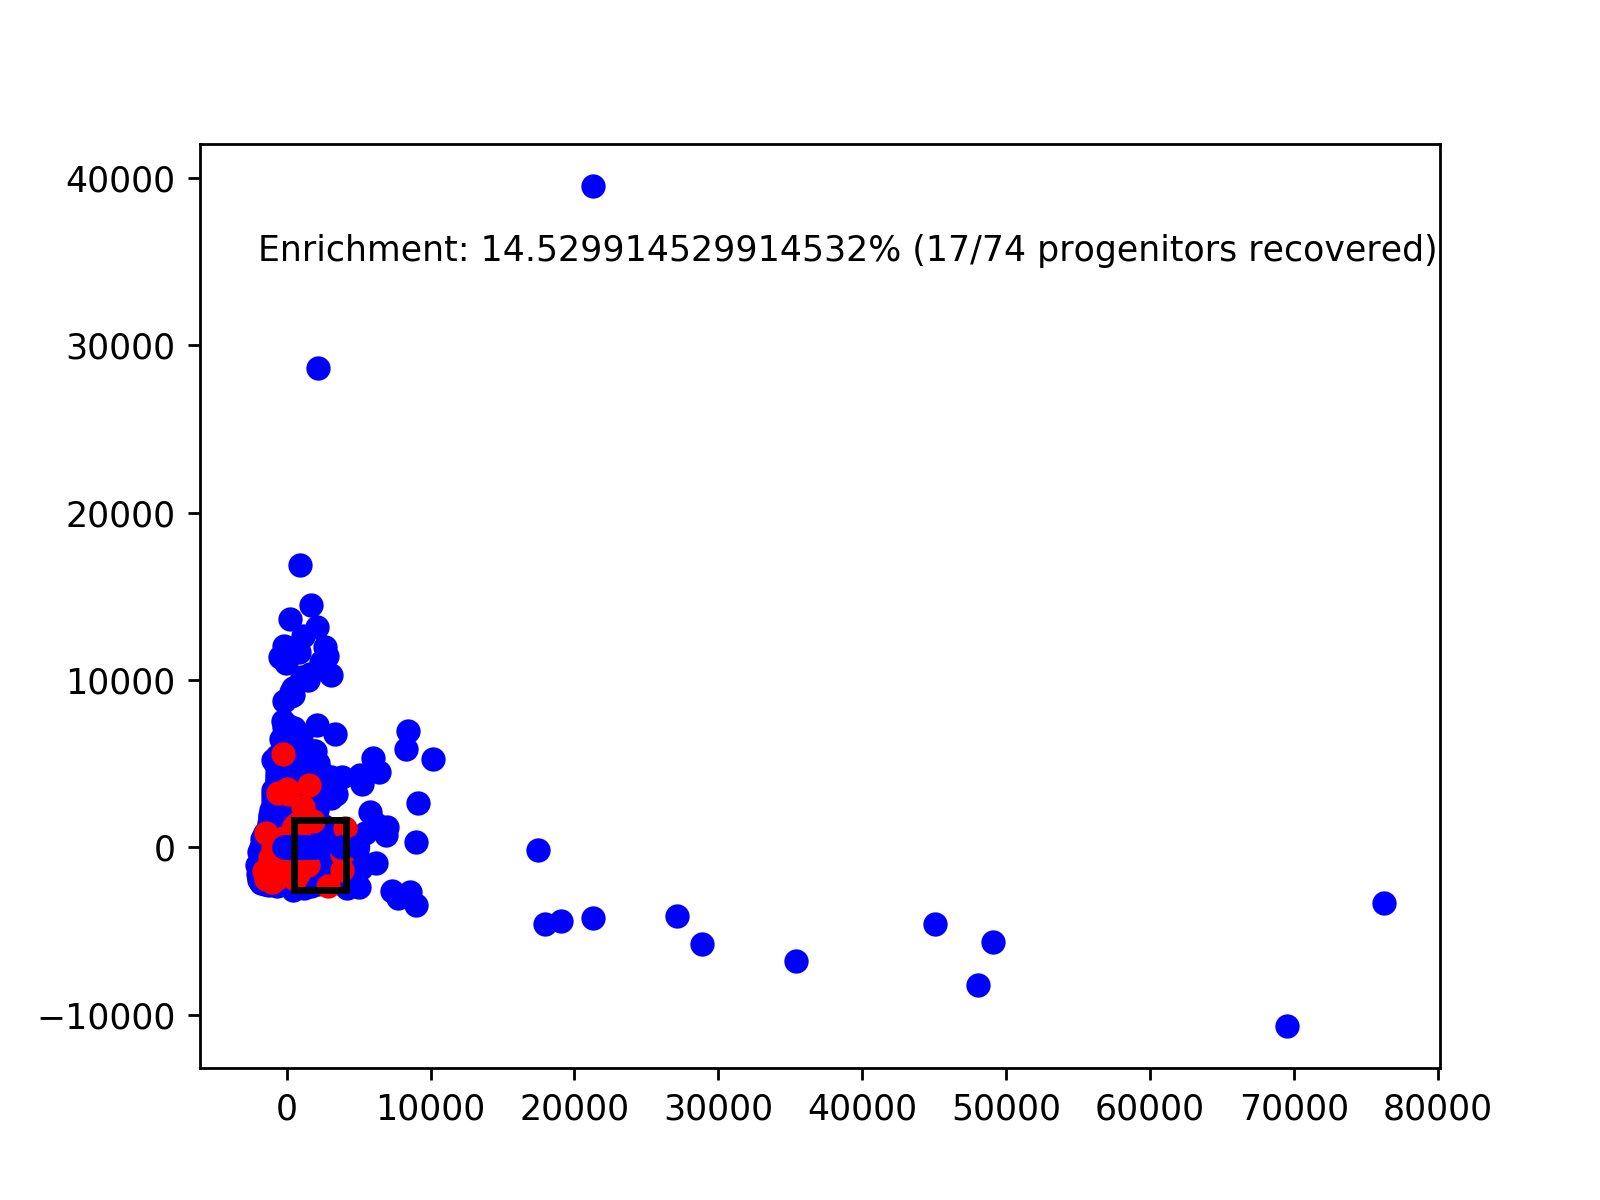

interactive(children=(FloatSlider(value=479.0, description='x', max=10000.0, min=-10000.0, step=1.0), FloatSli…

In [78]:
%matplotlib notebook
# show pca plot
pca = PCA(n_components=2)
X_ = pca.fit_transform(X)

nonprog_a, nonprog_b = [], []
prog_a, prog_b = [], []
for i in range(len(Y.values.tolist())):
    if Y.values.tolist()[i][0] == "Y":
        prog_a.append(X_[i, 0])
        prog_b.append(X_[i, 1])
    else:
        nonprog_a.append(X_[i, 0])
        nonprog_b.append(X_[i, 1])

plt.scatter(nonprog_a[:], nonprog_b[:], c=[[0,0,1]], cmap=plt.cm.Spectral)
plt.scatter(prog_a[:], prog_b[:], c=[[1,0,0]], cmap=plt.cm.Spectral)
plt.axis('tight')

plt.show()

def calc_enr(x, y, w, h):
    num_prog, num_nonprog = 0, 0
    for xx, yy, zz in zip(X_[:, 0], X_[:, 1], Y.values.tolist()):
        if xx > x and xx < x + w and yy > y and yy < y + h:
            if zz[0] == "Y":
                num_prog += 1
            else:
                num_nonprog += 1
    return (num_prog / num_nonprog) * 100, num_prog

# interactive to select gate
x, y, w, h = 479, -2562, 3623, 4177

# 12.389% enrichment with 208, -3277, 1358, 4557 (16)
# 12.5% enrichment with 208, -2900, 1358, 4370   (16)
# 12.97% enrichment with 388, -2713, 4243, 4218 (17)
# 13.23% enrichment with 388, -2562, 4243, 4218 (17)
# 13.93% enrichment with 479, -2562, 4243, 4218 (17)
# 14.4% enrichment with 479, -2562, 3623, 4218 (17)
# 14.5% enrichment with 479, -2562, 3623, 4177 (17)
# 44.44% enrichment with 2865, -2900, 1400, 4364 (4)

enr, num = calc_enr(x, y, w, h)
line1, = plt.plot([x, x+w], [y, y], color='k', linestyle='-', linewidth=2)
line2, = plt.plot([x, x+w], [y+h, y+h], color='k', linestyle='-', linewidth=2)
line3, = plt.plot([x, x], [y, y+h], color='k', linestyle='-', linewidth=2)
line4, = plt.plot([x+w, x+w], [y, y+h], color='k', linestyle='-', linewidth=2)
enrich = plt.text(-2000, 35000, "Enrichment: " + str(enr) + "% (" + str(num) + "/74 progenitors recovered)")

def update(x = x, y=y, w=w, h=h):
    line1.set_data([x, x+w], [y, y])
    line2.set_data([x, x+w], [y+h, y+h])
    line3.set_data([x, x], [y, y+h])
    line4.set_data([x+w, x+w], [y, y+h])
    enr, num = calc_enr(x, y, w, h)
    enrich.set_text("Enrichment: " + str(enr) + "% (" + str(num) + "/74 progenitors recovered)")
    fig.canvas.draw_idle()

interact(update,
         x = widgets.FloatSlider(value=x, min=-10000, max=10000, step=1),
         y = widgets.FloatSlider(value=y, min=-10000, max=10000, step=1),
         w = widgets.FloatSlider(value=w, min=-10000, max=10000, step=1),
         h = widgets.FloatSlider(value=h, min=-10000, max=10000, step=1)
        );

# show enrichment.


# Project backwards onto original dimensions

In [79]:
llims = pca.inverse_transform([x,y])
ulims = pca.inverse_transform([x+w,y+h])
llims, ulims

(array([-309.18104105,  342.02392006,   92.96115777, 1045.36215345,
         315.11735385,  224.99665793, 2358.14710357]),
 array([4165.463151  ,  757.5003078 ,  131.56773315,  848.2110913 ,
         563.30941102,  382.10964706, 5559.98312814]))

# Visualise individual marker

Green line = take everything greater than this

Red line = take everything less than this

In [80]:
marker = 4

col = np.array([[1,0,0] if a[0] == "Y" else [0,0,1] for a in Y.values.tolist()])
plt.scatter(X.values[:, marker], np.array([1 if a[0] == "Y" else 0 for a in Y.values.tolist()]), c=col, cmap=plt.cm.Spectral)

plt.plot([ulims[marker], ulims[marker]], [0, 1], color='r', linestyle='-', linewidth=2)
plt.plot([llims[marker], llims[marker]], [0, 1], color='g', linestyle='-', linewidth=2)

plt.show()

# Visualise results from all markers

<IPython.core.display.Javascript object>


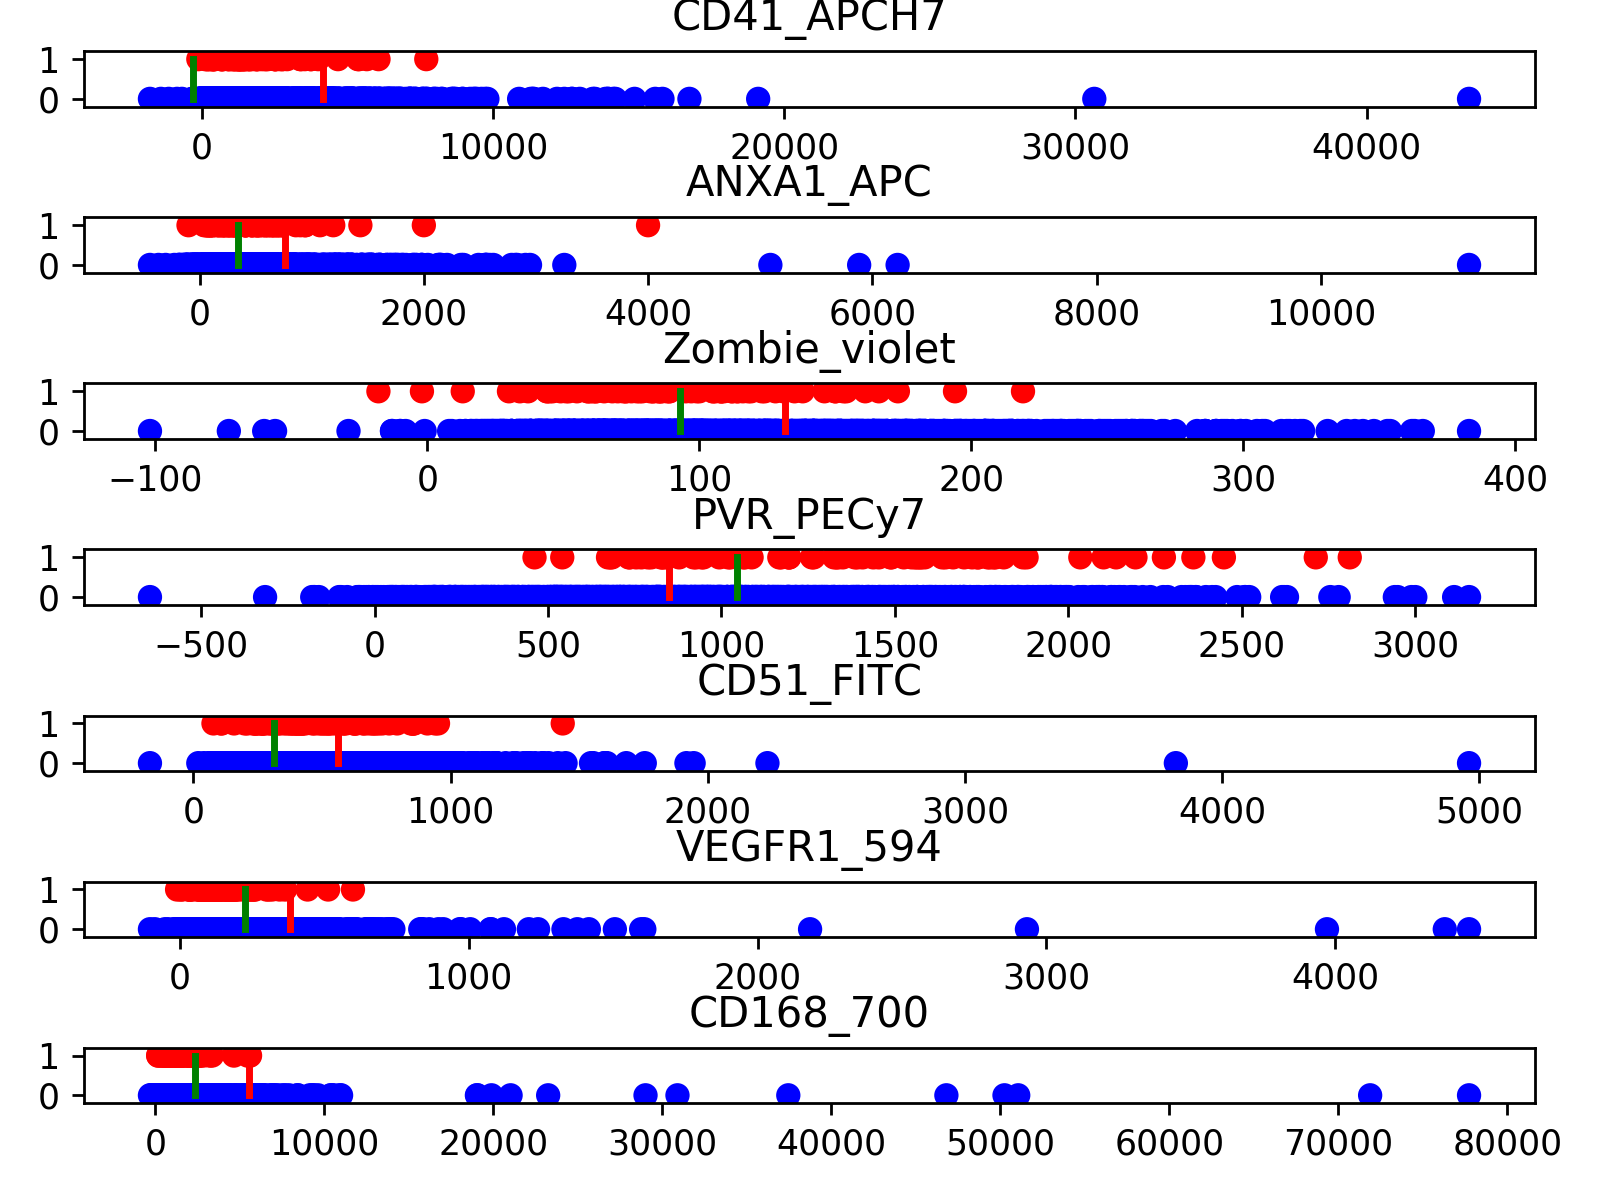

In [81]:
fig, axs = plt.subplots(7)
fig.tight_layout()

for marker in range(7):
    col = np.array([[1,0,0] if a[0] == "Y" else [0,0,1] for a in Y.values.tolist()])
    axs[marker].scatter(X.values[:, marker], np.array([1 if a[0] == "Y" else 0 for a in Y.values.tolist()]), c=col, cmap=plt.cm.Spectral)

    axs[marker].plot([ulims[marker], ulims[marker]], [0, 1], color='r', linestyle='-', linewidth=2)
    axs[marker].plot([llims[marker], llims[marker]], [0, 1], color='g', linestyle='-', linewidth=2)
    
    axs[marker].title.set_text(X.columns.values[marker])

plt.show()